---
title: "Rink maps"
description: "Scrape play-by-play data and plot shot maps with chickenstats and hockey-rink"
author: "chicken"
date: "2/18/2026"
categories:
    - "tutorials"
image: charts/nsh_forwards_rink_maps.png
lightbox: true
draft: false
---

## **Intro**

Use the `chickenstats` library to scrape play-by-play data and plot shot events using the hockey-rink library.

Parts of this tutorial are optional and will be clearly marked as such. For help, or any questions,
please don't hesitate to reach out to [chicken@chickenandstats.com](mailto:chicken@chickenandstats.com) or
[@chickenandstats.com](https://bsky.app/profile/chickenandstats.com) on Blue Sky.

---

![](charts/nsh_forwards_rink_maps.png)

---

## **Housekeeping**

### Import dependencies

Import the dependencies we'll need for the guide

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from hockey_rink import NHLRink

from chickenstats.chicken_nhl import Scraper, Season
from chickenstats.chicken_nhl._helpers import charts_directory, norm_coords
from chickenstats.chicken_nhl.team import NHL_COLORS

### Polars options

Sets different polars options. This cell is optional

In [ ]:
pl.Config.set_tbl_cols(-1)

polars.config.Config

### Folder structure

In [ ]:
charts_directory()

### Chickenstats matplotlib style

chickenstats.utilities includes a custom style package - this activates it. This cell is also optional

In [ ]:
plt.style.use("chickenstats")

---

## **Scrape data**

### Schedule and game IDs

Scrape the schedule and standings using the `Season` object. Then, create a list of game IDs to scrape

In [ ]:
season = Season(2025)

In [ ]:
schedule = season.schedule()

Output()

In [ ]:
standings = season.standings

In [ ]:
game_ids = schedule.filter(pl.col("game_state") == "OFF")["game_id"].to_list()

### Play-by-play

Scrape the play-by-play data for the list of game IDs. First instantiate the `Scraper` object,
then call the play_by_play attribute

In [ ]:
scraper = Scraper(game_ids)

In [ ]:
pbp = scraper.play_by_play

Output()

### Stats

Aggregate data using the `Scraper` object's built-in methods

In [ ]:
scraper.prep_stats(level="season")
stats = scraper.stats

Output()

In [ ]:
scraper.prep_lines(level="season")
lines = scraper.lines

Output()

In [ ]:
scraper.prep_team_stats(level="season")
team_stats = scraper.team_stats

Output()

---

## **Scatter plots**

### Drawing the rink 

Drawing the rink with the NHLRink class from the hockey-rink library

In [ ]:
rink = NHLRink(rotation=90)

### Filter conditions

Set the team, strength state, minimum TOI, and maximum number of lines to plot,
then filter the data

In [ ]:
team = "NSH"
strength_state = "5v5"
toi_min = 12
max_lines = 3

conditions = (pl.col("team") == team, pl.col("strength_state") == strength_state, pl.col("toi") >= toi_min)

plot_lines = lines.filter(conditions).sort("toi", descending=True).head(max_lines)

### Top-N forward line combos

Plot the top-N forward line combinations at the chosen strength state, from the prior cell

In [ ]:
# Setting overall figures
fig, axes = plt.subplots(nrows=2, ncols=max_lines, dpi=650, figsize=(16, 8))

fig.tight_layout(pad=1.5)

axes = axes.reshape(-1)

size_multiplier = 500

for row, line in enumerate(plot_lines.to_dicts()):
    ax = axes[row]

    ax_zone = "dzone" if row > 5 else "ozone"

    rink.draw(ax=ax, display_range=ax_zone)

    shot_events = ["MISS", "SHOT", "GOAL"]

    plot_conditions = (
        pl.col("forwards") == line["forwards"],
        pl.col("forwards_api_id") == line["forwards_api_id"],
        pl.col("strength_state") == strength_state,
        pl.col("event").is_in(shot_events),
    )

    plot_data = pbp.filter(plot_conditions).with_columns(pred_goal_size=pl.col("pred_goal") * size_multiplier)

    plot_data = norm_coords(plot_data, "event_team", line["team"])

    for shot_event in shot_events:
        conditions = (pl.col("forwards_api_id") == line["forwards_api_id"], pl.col("event") == shot_event)

        plot_data2 = plot_data.filter(conditions)

        if plot_data2.is_empty():
            continue

        colors = NHL_COLORS[plot_data2.item(0, "event_team")]

        facecolor = colors[shot_event]

        if shot_event == "MISS" or shot_event == "SHOT":
            edgecolor = "#FFFFFF"

        elif shot_event == "GOAL":
            edgecolor = colors["SHOT"] if facecolor == "#FFFFFF" else "#FFFFFF"

        rink.plot_fn(
            sns.scatterplot,
            data=plot_data2,
            x="norm_coords_x",
            y="norm_coords_y",
            color=facecolor,
            edgecolor=edgecolor,
            lw=0.75,
            s=plot_data2["pred_goal_size"],
            # sizes=(0, size_multiplier),
            size_norm=(0, size_multiplier),
            zorder=100,
            alpha=0.75,
            ax=ax,
        )

    ax.set_title(f"{line['forwards']}", x=0.5, y=1.01, ha="center", fontweight="bold", fontsize=10)


for row, line in enumerate(plot_lines.to_dicts()):
    row = row + max_lines

    ax = axes[row]

    ax_zone = "dzone" if row > max_lines - 1 else "ozone"

    rink.draw(ax=ax, display_range=ax_zone)

    plot_conditions = (
        pl.col("opp_forwards") == line["forwards"],
        pl.col("opp_forwards_api_id") == line["forwards_api_id"],
        pl.col("strength_state") == strength_state,
        pl.col("event").is_in(shot_events),
    )

    plot_data = pbp.filter(plot_conditions).with_columns(pred_goal_size=pl.col("pred_goal") * size_multiplier)

    plot_data = norm_coords(plot_data, "event_team", line["team"])

    for shot_event in shot_events:
        conditions = (pl.col("opp_forwards_api_id") == line["forwards_api_id"], pl.col("event") == shot_event)

        plot_data2 = plot_data.filter(conditions)

        if plot_data2.is_empty():
            continue

        colors = NHL_COLORS[plot_data2.item(0, "opp_team")]

        facecolor = colors[shot_event]

        if shot_event == "MISS" or shot_event == "SHOT":
            edgecolor = "#FFFFFF"

        elif shot_event == "GOAL":
            edgecolor = colors["SHOT"] if facecolor == "#FFFFFF" else "#FFFFFF"

        rink.plot_fn(
            sns.scatterplot,
            data=plot_data2,
            x="norm_coords_x",
            y="norm_coords_y",
            color=facecolor,
            edgecolor=edgecolor,
            lw=0.75,
            s=plot_data2["pred_goal_size"],
            # sizes=(0, size_multiplier),
            size_norm=(0, size_multiplier),
            zorder=100,
            alpha=0.75,
            ax=ax,
        )


fig_title = "Nashville forward lines aren't converting 5v5 scoring chances"

fig.suptitle(fig_title, x=0.5, y=1.1, fontweight="bold", fontsize=14)

subtitle = f"NSH top-{max_lines} forward line combinations by 5v5 TOI | 5v5 unblocked shot attempts for & against, sized for xG"
fig.text(s=subtitle, x=0.5, y=1.05, fontsize=12, ha="center")

attribution = "Data & xG model @chickenandstats | Viz @chickenandstats"
fig.text(s=attribution, x=0.95, y=-0.02, fontsize=12, ha="right", style="italic")

savepath = Path(f"./charts/{team.lower()}_forwards_rink_maps.png")
fig.savefig(savepath, transparent=False, bbox_inches="tight")

---

## **Contour plots**

### Drawing the rink 

Drawing the rink with the NHLRink class from the hockey-rink library

In [ ]:
rink = NHLRink(rotation=90)

### Filter conditions

Set the team, strength state, minimum TOI, and maximum number of players to plot,
then filter the data

In [ ]:
team = "NSH"
strength_states = ["5v4", "5v3", "4v3"]
positions = ["L", "C", "R", "L/R", "C/R", "R/L", "R/C"]
toi_min = 5
max_players = 6
group_columns = ["player", "api_id", "team"]  # "strength_state"]


conditions = (
    pl.col("team") == team,
    pl.col("strength_state").is_in(strength_states),
    pl.col("position").is_in(positions),
    pl.col("toi") >= toi_min,
)

plot_stats = (
    stats.filter(conditions)
    .group_by(group_columns)
    .agg([pl.col("ixg").sum(), pl.col("g").sum(), pl.col("toi").sum()])
    .sort(by="toi", descending=True)
    .head(max_players)
)

### Top-N forward shooters

Plot the top-N forwards' xG using the hockey-rink library and seaborn's kdeplot

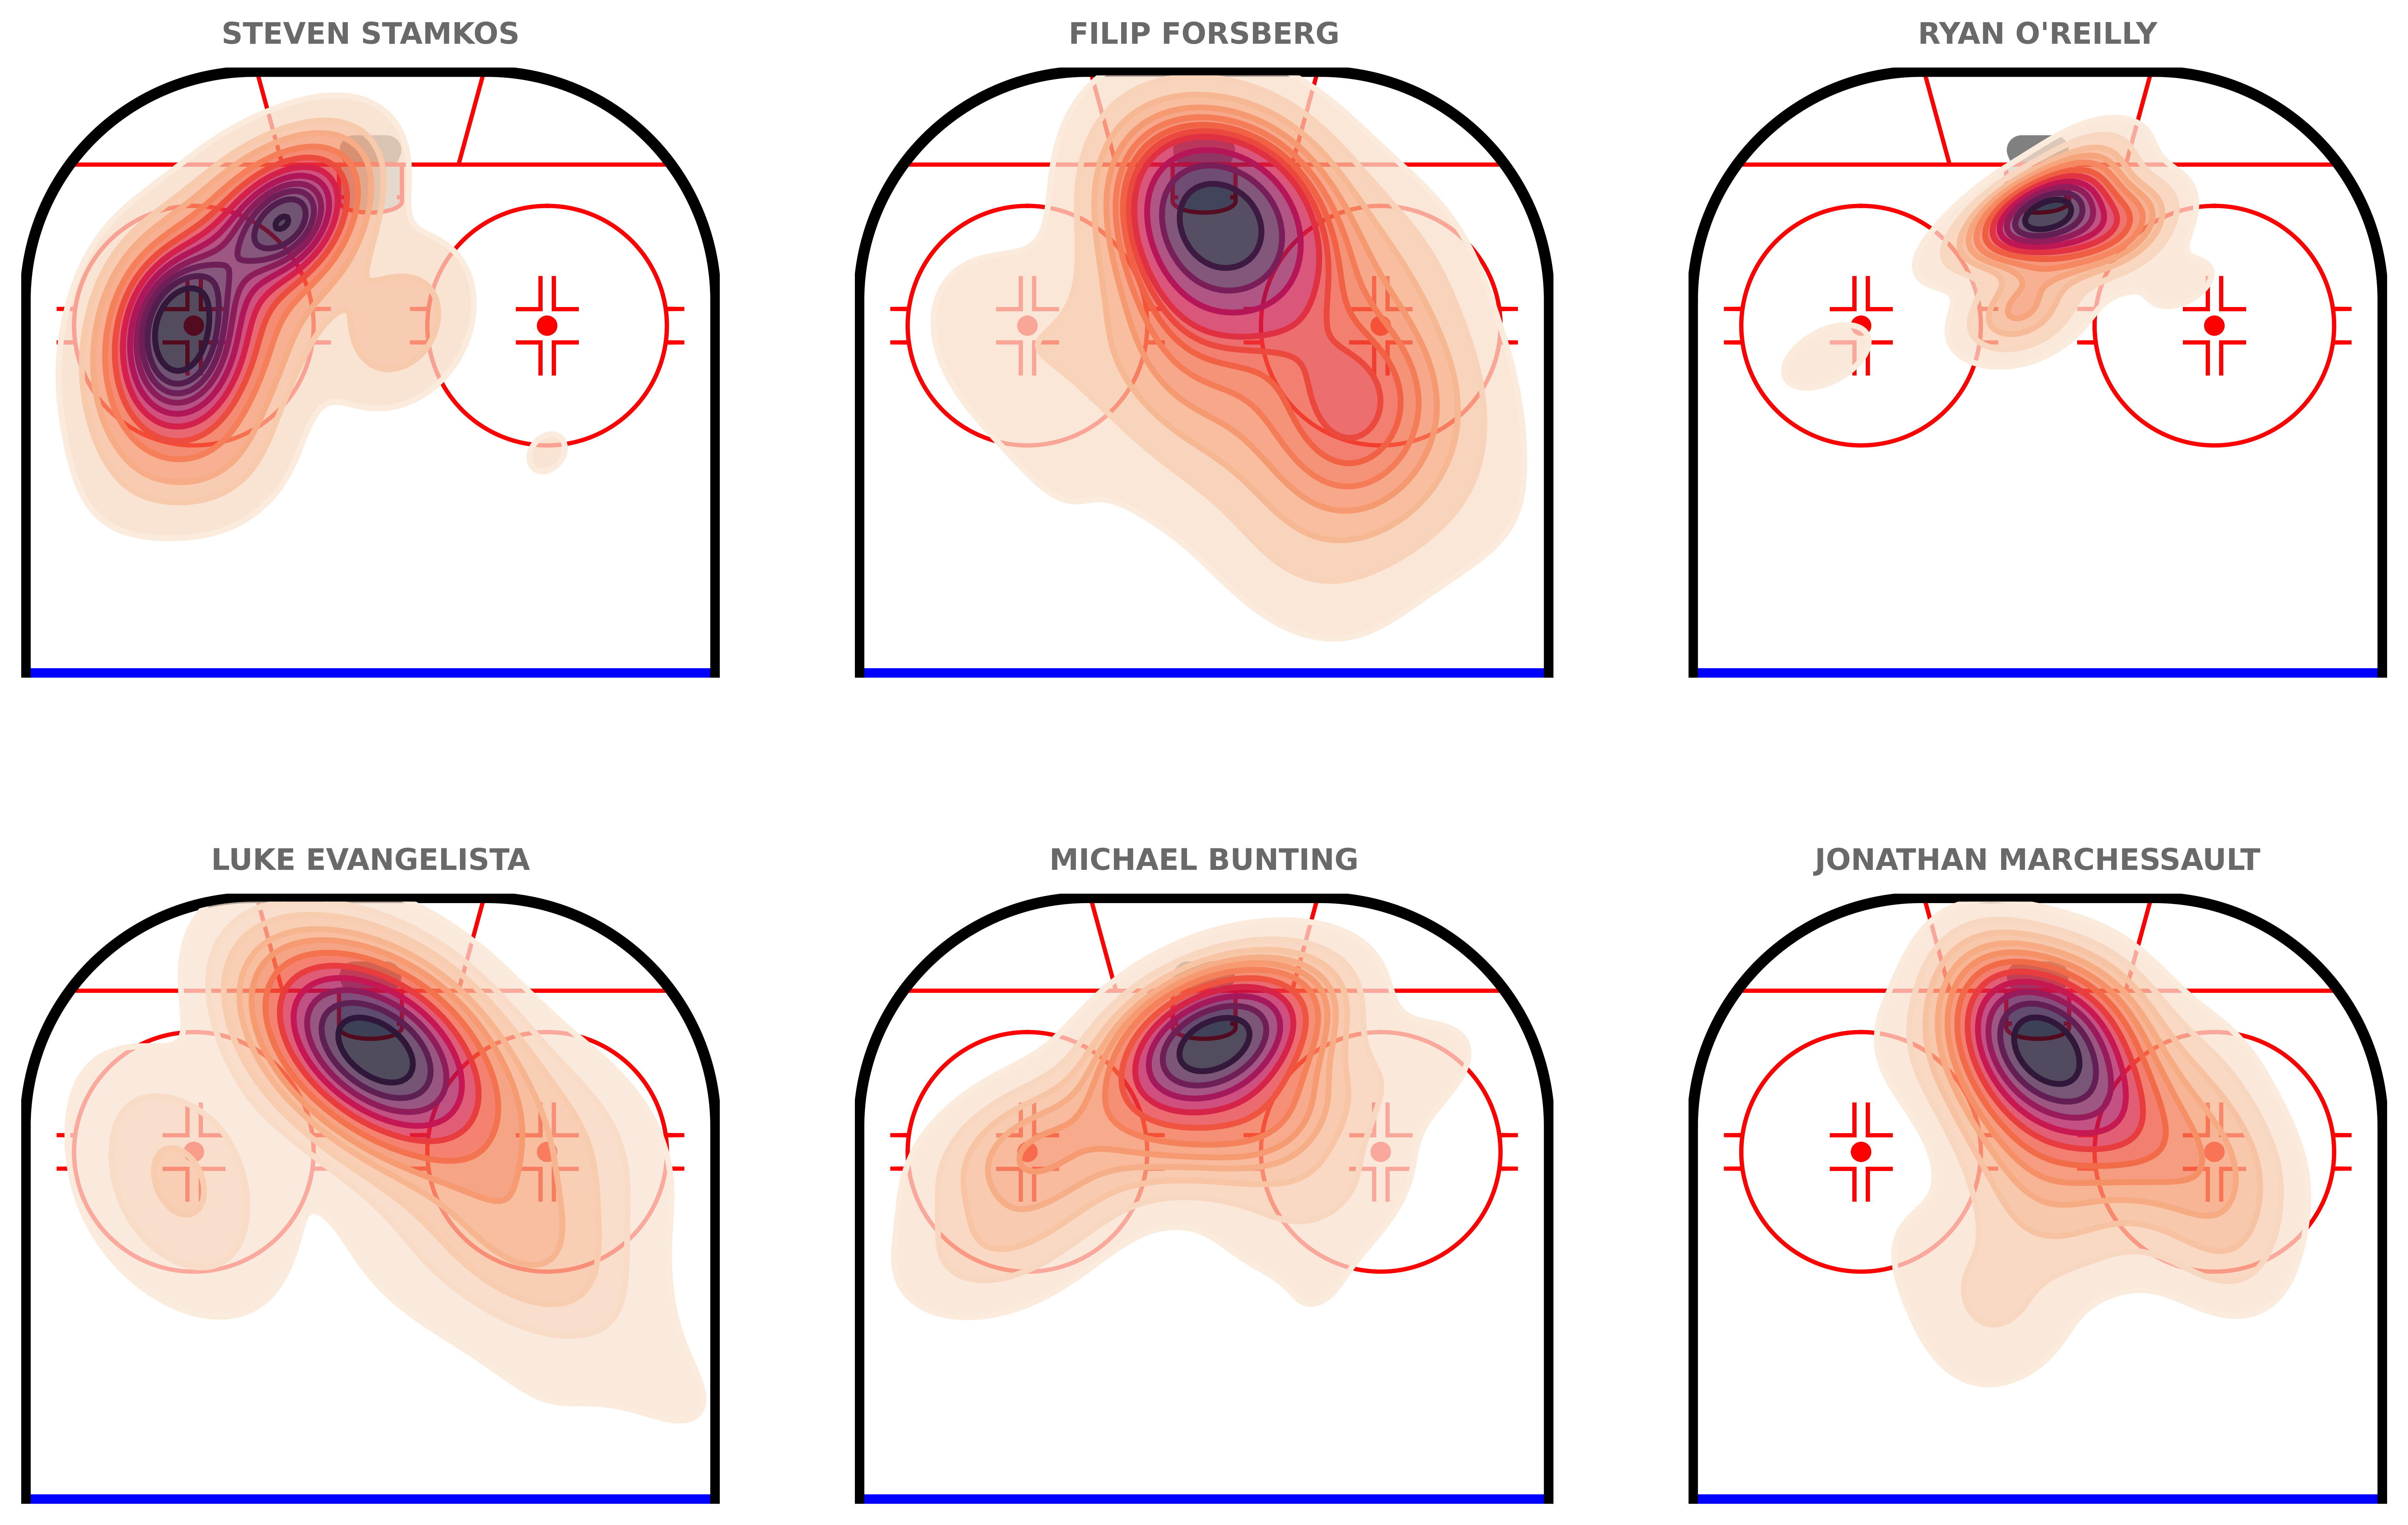

In [ ]:
cmap = "rocket_r"
weights = "pred_goal_p60"

fig, axes = plt.subplots(nrows=2, ncols=int(max_players / 2), dpi=650, figsize=(12, 8))

fig.tight_layout(pad=1.5)

axes = axes.reshape(-1)

for row, player in enumerate(plot_stats.to_dicts()):
    ax = axes[row]

    rink.draw(ax=ax, display_range="ozone")

    shot_events = ["MISS", "SHOT", "GOAL"]

    plot_conditions = (
        pl.col("player_1") == player["player"],
        pl.col("player_1_api_id").cast(str) == str(player["api_id"]),
        pl.col("strength_state").is_in(strength_states),
        pl.col("event").is_in(shot_events),
    )

    toi_minutes = plot_stats.filter(pl.col("api_id") == player["api_id"]).item(0, "toi")

    plot_data = pbp.filter(plot_conditions).with_columns(pred_goal_p60=(pl.col("pred_goal") / toi_minutes) * 60)

    plot_data = norm_coords(plot_data, "player_1_api_id", str(player["api_id"]))

    rink.plot_fn(
        sns.kdeplot,
        data=plot_data,
        x="norm_coords_x",
        y="norm_coords_y",
        cmap=cmap,
        fill=True,
        levels=12,
        weights=plot_data[weights],
        zorder=100,
        alpha=0.75,
        ax=ax,
        legend=True,
    )

    rink.plot_fn(
        sns.kdeplot,
        data=plot_data,
        x="norm_coords_x",
        y="norm_coords_y",
        cmap=cmap,
        fill=False,
        levels=12,
        linewidths=2,
        weights=plot_data[weights],
        zorder=110,
        alpha=1,
        ax=ax,
    )

    ax.set_title(f"{player['player']}", x=0.5, y=1.01, ha="center", fontweight="bold", fontsize=10)


save_path = Path(f"./charts/{team}_top_{max_players}_pp.png")

fig.savefig(save_path, transparent=False, bbox_inches="tight")